In [12]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import time
import tensorflow as tf
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [13]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data = data.dropna()  
    return data

def prepare_features_and_labels(data):
    features = ['TP2', 'DV_pressure', 'Oil_temperature', 'Motor_current', 'DV_eletric', 'Towers', 'LPS', 'Oil_level', 'Caudal_impulses']
    target = 'class'
    X = data[features].values
    y = data[target].values
    return X, y

def balance_and_sample(X, y, sample_fraction=0.4):
    """Sample and balance classes."""
    X, y = shuffle(X, y, random_state=42)
    sample_size = int(sample_fraction * len(X))
    X_sample, y_sample = X[:sample_size], y[:sample_size]
    
    classes = np.unique(y_sample)
    max_samples = max([np.sum(y_sample == cls) for cls in classes])
    
    X_balanced = []
    y_balanced = []
    
    for cls in classes:
        X_cls = X_sample[y_sample == cls]
        y_cls = y_sample[y_sample == cls]
        
        X_balanced.append(X_cls[:max_samples])
        y_balanced.append(y_cls[:max_samples])
    
    X_balanced = np.vstack(X_balanced)
    y_balanced = np.hstack(y_balanced)
    
    return X_balanced, y_balanced

def preprocess_data(data):
    if 'timestamp' not in data.columns or 'class' not in data.columns:
        raise ValueError("Data must contain 'timestamp' and 'class' columns.")
    
    data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
    data = data.dropna(subset=['timestamp'])
    data['month'] = data['timestamp'].dt.to_period('M')
    months = data['month'].astype(str).unique()
    
    if len(months) < 4:
        raise ValueError("Not enough distinct months to split into global and client data.")
    
    months.sort()
    first_two_months = months[:2]
    last_two_months = months[-2:]
    
    global_data = data[data['month'].astype(str).isin(first_two_months)]
    client1_data = data[data['month'].astype(str) == last_two_months[0]]
    client2_data = data[data['month'].astype(str) == last_two_months[1]]
    
    if global_data.empty or client1_data.empty or client2_data.empty:
        raise ValueError("One or more of the filtered datasets are empty.")
    
    return global_data, client1_data, client2_data


In [14]:
def create_sae_model(input_shape):
    """Create a Stacked Autoencoder (SAE) model."""
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [15]:
def compress_gradients_sparsification(gradients, sparsification_rate=99):
    """Apply gradient compression with sparsification.
    
    Arguments:
    gradients -- List of gradients to be compressed.
    sparsification_rate -- Percentage of gradients to be sparsified (default 99).
    
    Returns:
    compressed_gradients -- List of sparsified gradients.
    """
    compressed_gradients = []
    for grad in gradients:
        threshold = np.percentile(tf.abs(grad).numpy(), sparsification_rate)
        grad = tf.where(tf.abs(grad) > threshold, grad, tf.zeros_like(grad))
        compressed_gradients.append(grad)
    return compressed_gradients



In [16]:
def measure_communication_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    elapsed_time = time.time() - start_time
    return result, elapsed_time

def federated_learning(global_data, client1_data, client2_data, compression=False):
    X_global, y_global = prepare_features_and_labels(global_data)
    X_global, y_global = balance_and_sample(X_global, y_global, sample_fraction=0.4)
    
    X_client1, y_client1 = prepare_features_and_labels(client1_data)
    X_client2, y_client2 = prepare_features_and_labels(client2_data)
    X_client1, y_client1 = balance_and_sample(X_client1, y_client1, sample_fraction=0.4)
    X_client2, y_client2 = balance_and_sample(X_client2, y_client2, sample_fraction=0.4)
    
    model = create_sae_model(input_shape=(X_global.shape[1],))
    _, train_time_global = measure_communication_time(model.fit, X_global, y_global, epochs=10, batch_size=32, verbose=0)
    
    client_data = [(X_client1, y_client1, "Client 1"), (X_client2, y_client2, "Client 2")]
    communication_times = []
    
    for X_client, y_client, client_name in tqdm(client_data, desc="Clients", unit="client"):
        def train_func():
            model.fit(X_client, y_client, epochs=5, batch_size=32, verbose=0)
        
        _, update_time = measure_communication_time(train_func)
        communication_times.append(update_time)
        
        with tf.GradientTape() as tape:
            logits = model(X_client, training=True)
            y_client = tf.reshape(y_client, (-1, 1))
            loss = tf.keras.losses.binary_crossentropy(y_client, logits)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        
        if compression:
            gradients = compress_gradients_sparsification(gradients)
    
    y_global_pred = (model.predict(X_global) > 0.5).astype(int)
    accuracy = accuracy_score(y_global, y_global_pred)
    
    return np.mean(communication_times), accuracy


In [17]:
file_path = 'Metro-Both-Classes.csv'
data = load_and_preprocess_data(file_path)
global_data, client1_data, client2_data = preprocess_data(data)

# Run without gradient compression
comm_time_no_compression, accuracy_no_compression = federated_learning(global_data, client1_data, client2_data, compression=False)

# Run with gradient compression
comm_time_compression, accuracy_compression = federated_learning(global_data, client1_data, client2_data, compression=True)


Clients: 100%|██████████| 2/2 [00:48<00:00, 24.30s/client]

  49/5145 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step   

5145/5145 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


Clients: 100%|██████████| 2/2 [00:45<00:00, 22.53s/client]

  48/5145 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step   

5145/5145 ━━━━━━━━━━━━━━━━━━━━ 5s 971us/step


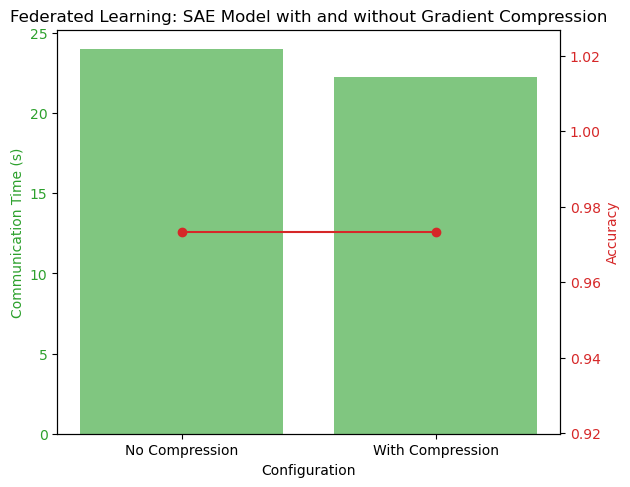

In [19]:
# Plot the results
labels = ['No Compression', 'With Compression']
communication_times = [comm_time_no_compression, comm_time_compression]
accuracies = [accuracy_no_compression, accuracy_compression]

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Configuration')
ax1.set_ylabel('Communication Time (s)', color=color)
ax1.bar(labels, communication_times, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(labels, accuracies, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Federated Learning: SAE Model with and without Gradient Compression")
plt.show()
